# Exploring the NHC Advisories and Sea Surface Height during Hurricane Irma


This notebook aims to demonstrate how to create a simple interactive GIS map with the National Hurricane Center predictions [1] and the observed sea surface height from CO-OPS [2].


See https://tidesandcurrents.noaa.gov/quicklook/view.html?name=IRMA for the latest information on Irma.

1. http://www.nhc.noaa.gov/gis/
2. https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/


First we have to download the National Hurricane Center (NHC) GIS 5 day predictions data for Irma.

NHC codes storms are coded with 8 letter names:
- 2 char for region `al` &rarr; Atlantic
- 2 char for number `11` is Irma
- and 4 char for year, `2017`

Browse http://www.nhc.noaa.gov/gis/forecast/archive to find other hurricanes code.

In [1]:
hurricane = '{}_5day'.format('al112017')

In [2]:
import os

import sys
try:
    from urllib.request import urlopen, urlretrieve
except:
    from urllib import urlopen, urlretrieve
import lxml.html


def url_lister(url):
    urls = []
    connection = urlopen(url)
    dom = lxml.html.fromstring(connection.read())
    for link in dom.xpath('//a/@href'):
        urls.append(link)
    return urls


def download(url, path):
    sys.stdout.write(fname + '\n')
    if not os.path.isfile(path):
        urlretrieve(
            url,
            filename=path,
            reporthook=progress_hook(sys.stdout)
        )
        sys.stdout.write('\n')
        sys.stdout.flush()


def progress_hook(out):
    """
    Return a progress hook function, suitable for passing to
    urllib.retrieve, that writes to the file object *out*.
    """

    def it(n, bs, ts):
        got = n * bs
        if ts < 0:
            outof = ''
        else:
            # On the last block n*bs can exceed ts, so we clamp it
            # to avoid awkward questions.
            got = min(got, ts)
            outof = '/%d [%d%%]' % (ts, 100 * got // ts)
        out.write("\r  %d%s" % (got, outof))
        out.flush()
    return it

In [3]:
nhc = 'http://www.nhc.noaa.gov/gis/forecast/archive/'

# We don't need the latest file b/c that is reduntant to the latest number.
fnames = [
    fname for fname in url_lister(nhc)
    if fname.startswith(hurricane) and 'latest' not in fname
]

In [4]:
base = os.path.abspath(
    os.path.join(os.path.curdir, 'data', hurricane)
)

if not os.path.exists(base):
    os.makedirs(base)

for fname in fnames:
    url = '{}/{}'.format(nhc, fname)
    path = os.path.join(base, fname)
    download(url, path)

al112017_5day_001.zip
al112017_5day_002.zip
al112017_5day_003.zip
al112017_5day_004.zip
al112017_5day_005.zip
al112017_5day_006.zip
al112017_5day_007.zip
al112017_5day_008.zip
al112017_5day_009.zip
al112017_5day_010.zip
al112017_5day_011.zip
al112017_5day_012.zip
al112017_5day_013.zip
al112017_5day_014.zip
al112017_5day_015.zip
al112017_5day_016.zip
al112017_5day_017.zip
al112017_5day_018.zip
al112017_5day_018A.zip
al112017_5day_019.zip
al112017_5day_019A.zip
al112017_5day_020.zip
al112017_5day_020A.zip
al112017_5day_021.zip
al112017_5day_021A.zip
al112017_5day_022.zip
al112017_5day_022A.zip
al112017_5day_023.zip
al112017_5day_023A.zip
al112017_5day_024.zip
al112017_5day_025.zip
al112017_5day_026.zip
al112017_5day_026A.zip
al112017_5day_027.zip
al112017_5day_027A.zip
al112017_5day_028.zip
al112017_5day_028A.zip
al112017_5day_029.zip
al112017_5day_029A.zip
al112017_5day_030.zip
al112017_5day_030A.zip
al112017_5day_031.zip
al112017_5day_031A.zip
al112017_5day_032.zip
al112017_5day_032A.z

In the cells below we use `geopandas` to load the data we just downloaded. We will use only the prediction cone (`png`) and the track points (`pts`), but feel free to explore this data further, there is plenty more there.

In [5]:
from glob import glob
import geopandas


cones, points = [], []
for fname in sorted(glob(os.path.join(base, 'al112017_5day_*.zip'))):
    number = os.path.splitext(os.path.split(fname)[-1])[0].split('_')[-1]
    pgn = geopandas.read_file(
        '/al112017-{}_5day_pgn.shp'.format(number),
        vfs='zip://{}'.format(fname)
    )
    cones.append(pgn)

    pts = geopandas.read_file(
        '/al112017-{}_5day_pts.shp'.format(number),
        vfs='zip://{}'.format(fname)
    )
    # Only the first "obsevartion."
    points.append(pts.iloc[0])

Let's create a color code for the point track.

In [6]:
colors = {
    'Tropical Storm': 'yellow',
    'Hurricane': 'red',
    'Major Hurricane': 'crimson',
    'Subtropical Depression': 'darkorange',
    'Tropical Depression': 'orange'
}

Now we can get all the information we need from those GIS files. Let's start with the event dates.

In [7]:
import arrow

# We are ignoring the timezone, like AST (Atlantic Time Standar) b/c
# those are not a unique identifiers and we cannot disambiguate.
start = points[0]['FLDATELBL']
end = points[-1]['FLDATELBL']

start = arrow.get(start, 'YYYY-MM-DD h:mm A ddd').naive
end = arrow.get(end, 'YYYY-MM-DD h:mm A ddd').naive

And the bounding box to search the data.

In [8]:
from shapely.geometry import LineString

track = LineString([point['geometry'] for point in points])

# Add a buffer to find the stations along the track.
polygon = track.buffer(2)
bbox = polygon.bounds

In [9]:
strbbox = ', '.join(format(v, '.2f') for v in bbox)
print('bbox: {}\nstart: {}\n  end: {}'.format(strbbox, start, end))

bbox: -86.90, 14.40, -28.30, 34.40
start: 2017-08-30 08:00:00
  end: 2017-09-11 20:00:00


In [10]:
# from datetime import datetime, timedelta

# event_date = datetime(2017, 9, 7)

# start = event_date - timedelta(days=3)
# end = event_date + timedelta(days=4)

Now we need to build a filter with those parameters to find the observations along the Hurricane path. We still need to specify:

- the units for the observations;
- and the SOS name for the variables of interest.

Next, we can use `pyoos` to assemble a collector to download the data into a pandas `DataFrame`.

In [11]:
import cf_units
from ioos_tools.ioos import collector2table
import pandas as pd
from pyoos.collectors.coops.coops_sos import CoopsSos
from retrying import retry


# We need to retry in case of failure b/c the server cannot handle
# the high traffic during events like Irma.
@retry(stop_max_attempt_number=5, wait_fixed=3000)
def get_coops(start, end, sos_name, units, bbox, verbose=False):
    collector = CoopsSos()
    collector.set_bbox(bbox)
    collector.end_time = end
    collector.start_time = start
    collector.variables = [sos_name]
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    config = dict(
        units=units,
        sos_name=sos_name,
    )

    data = collector2table(
        collector=collector,
        config=config,
        col='{} ({})'.format(sos_name, units.format(cf_units.UT_ISO_8859_1))
    )

    # Clean the table.
    table = dict(
        station_name=[s._metadata.get('station_name') for s in data],
        station_code=[s._metadata.get('station_code') for s in data],
        sensor=[s._metadata.get('sensor') for s in data],
        lon=[s._metadata.get('lon') for s in data],
        lat=[s._metadata.get('lat') for s in data],
        depth=[s._metadata.get('depth', 'NA') for s in data],
    )

    table = pd.DataFrame(table).set_index('station_name')
    if verbose:
        print('Collector offerings')
        print('{}: {} offerings'.format(title, len(ofrs)))
    return data, table

In [12]:
ssh, ssh_table = get_coops(
    start=start,
    end=end,
    sos_name='water_surface_height_above_reference_datum',
    units=cf_units.Unit('meters'),
    bbox=bbox,
)

ssh_table

,depth,lat,lon,sensor,station_code
station_name,,,,,
"Bermuda, Ferry Reach Channel, Bermuda",None,32.3700,-64.6950,urn:ioos:sensor:NOAA.NOS.CO-OPS:2695535:N1,2695535
"Bermuda, St. Georges Island, Bermuda",None,32.3733,-64.7033,urn:ioos:sensor:NOAA.NOS.CO-OPS:2695540:Y1,2695540
"Wilmington, NC",None,34.2275,-77.9536,urn:ioos:sensor:NOAA.NOS.CO-OPS:8658120:A1,8658120
"Wrightsville Beach, NC",None,34.2133,-77.7867,urn:ioos:sensor:NOAA.NOS.CO-OPS:8658163:A1,8658163
"Springmaid Pier, SC",None,33.6550,-78.9183,urn:ioos:sensor:NOAA.NOS.CO-OPS:8661070:Y1,8661070
"Oyster Landing (N Inlet Estuary), SC",None,33.3517,-79.1867,urn:ioos:sensor:NOAA.NOS.CO-OPS:8662245:A1,8662245
"Charleston, Cooper River Entrance, SC",None,32.7808,-79.9236,urn:ioos:sensor:NOAA.NOS.CO-OPS:8665530:A1,8665530
"Fort Pulaski, GA",None,32.0367,-80.9017,urn:ioos:sensor:NOAA.NOS.CO-OPS:8670870:A1,8670870
"Fernandina Beach, FL",None,30.6714,-81.4658,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720030:Y1,8720030


In [13]:
wind_speed, wind_speed_table = get_coops(
    start=start,
    end=end,
    sos_name='wind_speed',
    units=cf_units.Unit('m/s'),
    bbox=bbox,
)

wind_speed_table

,depth,lat,lon,sensor,station_code
station_name,,,,,
"Bermuda, St. Georges Island, Bermuda",None,32.3733,-64.7033,urn:ioos:sensor:NOAA.NOS.CO-OPS:2695540:C1,2695540
"Wrightsville Beach, NC",None,34.2133,-77.7867,urn:ioos:sensor:NOAA.NOS.CO-OPS:8658163:C1,8658163
"Charleston, Cooper River Entrance, SC",None,32.7808,-79.9236,urn:ioos:sensor:NOAA.NOS.CO-OPS:8665530:C1,8665530
"Fort Pulaski, GA",None,32.0367,-80.9017,urn:ioos:sensor:NOAA.NOS.CO-OPS:8670870:C1,8670870
"Fernandina Beach, FL",None,30.6714,-81.4658,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720030:C1,8720030
"Navy Fuel Depot, FL",None,30.4000,-81.6267,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720215:C1,8720215
"Mayport (Bar Pilots Dock), FL",None,30.3982,-81.4279,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720218:C1,8720218
"Blount Island Command, FL",None,30.3926,-81.5225,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720233:C1,8720233
"I-295 Bridge, St Johns River, FL",None,30.1917,-81.6917,urn:ioos:sensor:NOAA.NOS.CO-OPS:8720357:C1,8720357


For simplicity we will use only the stations that have both wind speed and sea surface height and reject those that have only one or the other.

In [14]:
common = set(ssh_table['station_code']).intersection(wind_speed_table['station_code'])

In [15]:
ssh_obs, win_obs = [], []
for station in common:
    ssh_obs.extend([obs for obs in ssh if obs._metadata['station_code'] == station])
    win_obs.extend([obs for obs in wind_speed if obs._metadata['station_code'] == station])

In [16]:
index = pd.date_range(
    start=start.replace(tzinfo=None),
    end=end.replace(tzinfo=None),
    freq='15min'
)

# Re-index and rename series.
ssh_observations = []
for series in ssh_obs:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    obs.name = _metadata['station_name']
    ssh_observations.append(obs)

winds_observations = []
for series in win_obs:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    obs.name = _metadata['station_name']
    winds_observations.append(obs)

Let's take a look at some stations to see if the data is OK. Below we have a station in Naples, FL along the Gulf of Mexico.

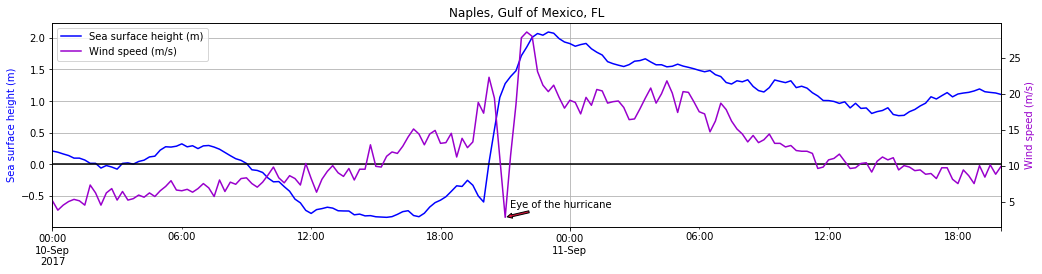

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

w = [obs for obs in winds_observations if obs._metadata['station_code'] == '8725110'][0]
s = [obs for obs in ssh_observations if obs._metadata['station_code'] == '8725110'][0]

fig, ax = plt.subplots(figsize=(17, 3.75))
s['2017-9-10':].plot(ax=ax, label='Sea surface height (m)', color='#0000ff')
ax1 = w['2017-9-10':].plot(ax=ax, label='Wind speed (m/s)', color='#9900cc', secondary_y=True)
ax.set_title(w._metadata['station_name'])

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper left')
ax.axhline(0, color='black')

ax.set_ylabel('Sea surface height (m)', color='#0000ff')
ax.right_ax.set_ylabel('Wind speed (m/s)', color='#9900cc')

ax1.annotate(
    'Eye of the hurricane',
    xy=(w['2017-9-10':].argmin().to_pydatetime(), w['2017-9-10':].min()),
    xytext=(5, 10),
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle='simple',
        facecolor='crimson'
    ),
)

ax.grid(True)

We can observe the sea level retreating around 10-Sep 9:00 and then a significant surge after 19:00.
The lower winds at beginning of the surge is probably the eye of the hurricane.

For our interactive map we will use [`bokeh`](https://bokeh.pydata.org/en/latest/) HTML plots instead of the usual raster `matplotlib` ones to enhance the user experience when exploring the graphs.

In [18]:
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.models import Range1d, LinearAxis

from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(ssh, wind):
    p = figure(toolbar_location="above",
               x_axis_type="datetime",
               width=width,
               height=height,
               tools=tools,
               title=ssh.name)
    p.yaxis.axis_label = 'wind speed (m/s)'
    p.line(
        x=wind.index,
        y=wind.values,
        line_width=5,
        line_cap='round',
        line_join='round',
        legend='wind speed (m/s)',
        color='#9900cc',
        alpha=0.5,
    )
    p.extra_y_ranges = {}
    p.extra_y_ranges['y2'] = Range1d(
        start=-1,
        end=3.5
    )
    p.add_layout(
        LinearAxis(y_range_name='y2', axis_label='ssh (m)'),
        'right'
    )
    p.line(
        x=ssh.index,
        y=ssh.values,
        line_width=5,
        line_cap='round',
        line_join='round',
        legend='ssh (m)',
        color='#0000ff',
        alpha=0.5,
        y_range_name='y2',
    )
    p.legend.location = 'top_left'
    return p


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width+45, height=height+80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=location,
                           popup=popup,
                           icon=icon)
    return marker

Here is the final result. Explore the map by clicking on the map features plotted!

In [19]:
import folium
from folium.plugins import Fullscreen, MarkerCluster

lon = track.centroid.x
lat = track.centroid.y

m = folium.Map(location=[lat, lon], tiles='OpenStreetMap', zoom_start=4)

Fullscreen(position='topright', force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name='Observations')
marker_cluster1 = MarkerCluster(name='Past predictions')
marker_cluster0.add_to(m)
marker_cluster1.add_to(m)


url = 'http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km'
w0 = folium.WmsTileLayer(
    url,
    name='Sea Surface Temperature',
    fmt='image/png',
    layers='CRW_SST',
    attr='PacIOOS TDS',
    overlay=True,
    transparent=True)

w0.add_to(m)

url = 'http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV'
w1 = folium.WmsTileLayer(
    url,
    name='HF Radar',
    fmt='image/png',
    layers='surface_sea_water_velocity',
    attr='HFRNet',
    overlay=True,
    transparent=True)

w1.add_to(m)


def style_function(feature):
    return {
        'fillOpacity': 0,
        'color': 'black',
        'stroke': 1,
        'weight': 0.5,
        'opacity': 0.2,
    }


# Latest cone prediction.
latest = cones[-1]
folium.GeoJson(
    data=latest.__geo_interface__,
    name='Cone prediction as of {}'.format(latest['ADVDATE'].values[0]),
).add_to(m)

# Past cone predictions.
for cone in cones[:-1]:
    folium.GeoJson(
        data=cone.__geo_interface__,
        style_function=style_function,
    ).add_to(marker_cluster1)

# Latest points prediction.
for k, row in pts.iterrows():
    date = row['FLDATELBL']
    hclass = row['TCDVLP']
    location = row['LAT'], row['LON']
    popup = '{}<br>{}'.format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=10,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)

# All the points along the track.
for point in points:
    date = point['FLDATELBL']
    hclass = point['TCDVLP']
    location = point['LAT'], point['LON']
    popup = '{}<br>{}'.format(date, hclass)
    folium.CircleMarker(
        location=location,
        radius=5,
        fill=True,
        color=colors[hclass],
        popup=popup,
    ).add_to(m)


# Observations.
for ssh, wind in zip(ssh_observations, winds_observations):
    fname = ssh._metadata['station_code']
    location = ssh._metadata['lat'], ssh._metadata['lon']
    p = make_plot(ssh, wind)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(marker_cluster0)

folium.LayerControl().add_to(m)

m.save('irma.html')

In [20]:
from IPython.display import IFrame


url = 'https://ioos.github.io/notebooks_demos/HTML/irma.html'
IFrame(src=url, width=950, height=500)